In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
import math
from scipy.stats.mstats import gmean
from scipy.stats import gamma, poisson, linregress, beta, norm, lognorm
from scipy import optimize
from scipy import interpolate
import time
import random
import pickle as pkl
from cratrcountr import *
%matplotlib inline

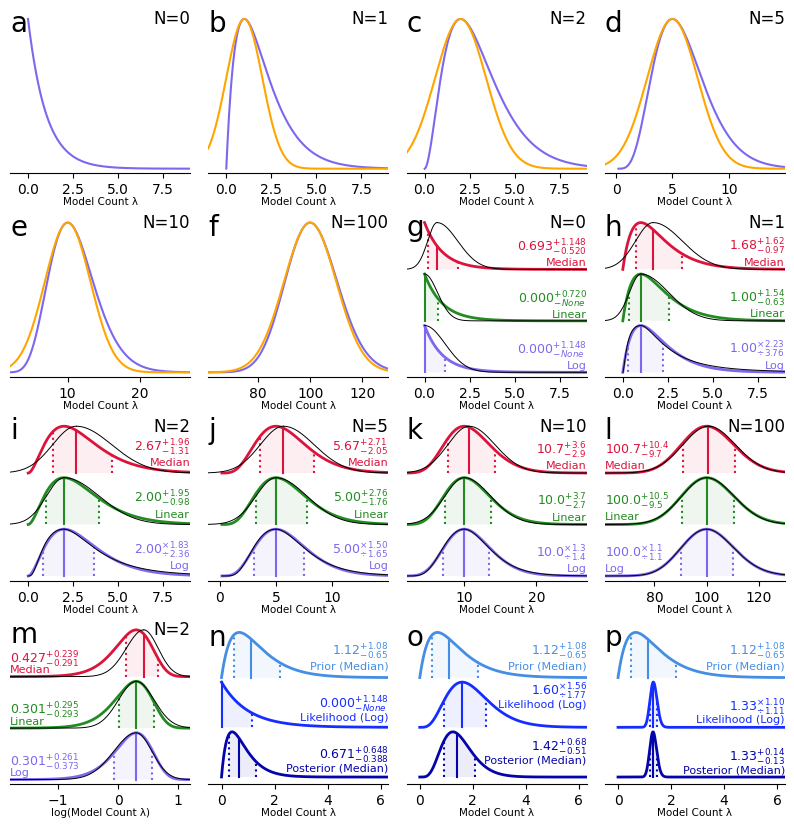

In [2]:
xlim = [-1, 9]
def customized_plotting_parameters(N, letter, xlim=[-1, 9]):
    plt.xlim(xlim)
    plt.ylim(-0.1, 3.3)
    plt.text(
        xlim[0], 1.2 + 1.1 * 2, letter, 
        ha='left', va='top', size=20
    )
    plt.text(
        xlim[1], 1.0 * (1 + 1.1 * 2), 'N=' + str(N), 
        ha='right', va='center', size=12
    )

def customized_PDF_comparison_plot(N, letter, xlim=None, dn=None):
    erase_box(plt.gca())
    if dn is not None:
        rounding_n = 1
    else:
        rounding_n = 2
    true_error_pdf_N = true_error_pdf(N).standardize()
    plt.plot(
        true_error_pdf_N.X, 3.2 * true_error_pdf_N.P, 
        color='mediumslateblue'
    )
    if N > 0:
        sqrt_N_error_pdf_N = sqrt_N_error_pdf(N).standardize()
        plt.plot(
            sqrt_N_error_pdf_N.X, 3.2 * sqrt_N_error_pdf_N.P, 
            color='orange'
        )
    customized_plotting_parameters(N, letter, xlim=xlim)
    plt.xlabel('Model Count λ', labelpad=0, size=7.5)

fig = plt.figure(figsize=(10, 10))
Ns = [0, 1, 2, 5, 10, 100]
letters = list('abcdef')
xlims = [xlim, xlim, xlim, [-1, 14.99], [2, 27], [61, 130]]
dns = 5 * [None] + [0]
for i in range(6):
    N = Ns[i]
    letter = letters[i]
    ax = fig.add_subplot(441 + i)
    customized_PDF_comparison_plot(N, letter, xlim=xlims[i], dn=dns[i])

def customized_error_bar_comparison_plot(N, letter, xlim=None, dn=None):
    erase_box(plt.gca())
    if dn is not None:
        rounding_n = 1
    else:
        rounding_n = 2
    true_error_pdf(N).plot(
        color='mediumslateblue', label=True, dn=dn, 
        label_text_size=9, pdf_label='Log', xlim=xlim,
        rounding_n=rounding_n
    )
    if N > 0:
        plot_log_of_normal_approximation(N, color='black', linewidth=0.7)
    elif N == 0:
        plot_linear_approximation(
            0, color='black', linewidth=0.7, 
            forced_right_error=N_0_dict['log'][2]
        )
        
    true_error_pdf(N, kind='linear').plot(
        color='forestgreen', label=True, upshift=1.1, dn=dn,
        label_text_size=9, pdf_label='Linear', xlim=xlim,
        rounding_n=rounding_n
    )
    plot_linear_approximation(N, color='black', linewidth=0.7, upshift=1.1)
    true_error_pdf(N, kind='median').plot(
        color='crimson', label=True, upshift=2 * 1.1, dn=dn,
        label_text_size=9, pdf_label='Median', xlim=xlim,
        rounding_n=rounding_n
    )
    plot_median_approximation(N, color='black', linewidth=0.7, upshift=2.2)
    customized_plotting_parameters(N, letter, xlim=xlim)
    plt.xlabel('Model Count λ', labelpad=0, size=7.5)

letters = list('ghijkl')
for i in range(6):
    N = Ns[i]
    letter = letters[i]
    ax = fig.add_subplot(4, 4, 7 + i)
    customized_error_bar_comparison_plot(N, letter, xlim=xlims[i], dn=dns[i])

def customized_error_bar_comparison_log_plot(
    N, letter, xlim=None, dn=None, pdf_gap_shift=-0.1
):
    erase_box(plt.gca())
    true_error_pdf(N).log().plot(
        color='mediumslateblue', xlim=xlim, label=True, 
        label_text_size=9, pdf_label='Log', pdf_gap_shift=pdf_gap_shift
    )
    plot_log_of_normal_approximation(
        N, color='black', linewidth=0.7, log_space=True
    )
    true_error_pdf(N, kind='linear').log().plot( 
        color='forestgreen', xlim=xlim, label=True, upshift=1.1,
        label_text_size=9, pdf_label='Linear', pdf_gap_shift=pdf_gap_shift
    )
    plot_linear_approximation(
        N, color='black', linewidth=0.7, log_space=True, upshift=1.1
    )
    true_error_pdf(N, kind='median').log().plot( 
        color='crimson', xlim=xlim, label=True, upshift=2.2,
        label_text_size=9, pdf_label='Median', pdf_gap_shift=pdf_gap_shift
    )
    plot_median_approximation(
        N, color='black', linewidth=0.7, log_space=True, upshift=2.2
    )
    plt.ylim(-0.1, 3.3)
    customized_plotting_parameters(N, letter, xlim=xlim)
    plt.xlabel('log(Model Count λ)', labelpad=0, size=7.5)

ax = fig.add_subplot(4, 4, 13)
customized_error_bar_comparison_log_plot(2, 'm', xlim=[-1.8, 1.2])

def customized_prior_PDF_plot(
    N, letter, division_factor=1.0, xlim=[-0.5, 6.3], 
    m_prior=3.5, m_likelihood=3.1, m_posterior=2.5, ppgs=-0.05,
    llsy=0
):
    erase_box(plt.gca())
    prior = true_error_pdf(1) / 1.5
    likelihood = (true_error_pdf(N) / division_factor).match_X_of(prior)
    posterior = prior.update(likelihood).as_kind('median')
    lsy = prior.standardize()[m_prior] + 0.02
    prior.as_kind('median').plot(
        color=cs[0], upshift=1.1 * 2, label=True, label_text_size=9,
        pdf_label='Prior (Median)', xlim=xlim, label_shift_y=lsy
    )
    lsy = likelihood.standardize()[m_likelihood] + 0.02 + llsy
    likelihood.plot(
        color=cs[1], upshift=1.1 * 1, label=True, label_text_size=9,
        pdf_label='Likelihood (Log)', xlim=xlim, label_shift_y=lsy,
        pdf_gap_shift=ppgs
    )
    lsy = posterior.standardize()[m_posterior] + 0.02
    posterior.plot(
        color=cs[2], label=True, label_text_size=9,
        pdf_label='Posterior (Median)', xlim=xlim, label_shift_y=lsy,
        pdf_gap_shift=ppgs
    )
    plt.text(xlim[0], 1.2 + 1.1 * 2, letter, ha='left', va='top', size=20)
    plt.xlabel('Model Count λ', labelpad=0, size=7.5)

for i, N, letter, df in zip(
    range(14, 17), [0, 4, 100], list('nop'), [1, 2.5, 75]
):
    ax = fig.add_subplot(4, 4, i)
    customized_prior_PDF_plot(N, letter, division_factor=df)

plt.subplots_adjust(wspace=0.1, hspace=0.28)
pfig = plt.gcf()
pfig.savefig('figs/prior_explanation.pdf', bbox_inches='tight')

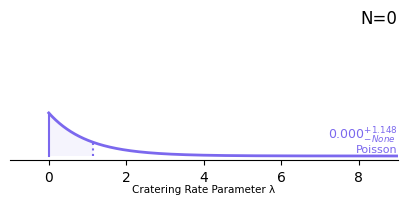

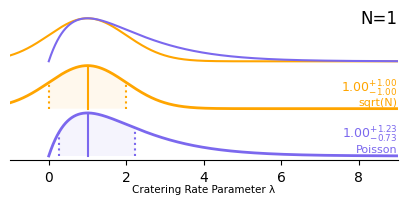

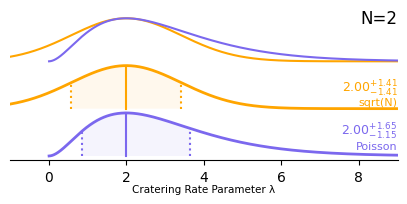

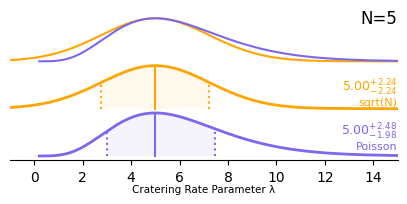

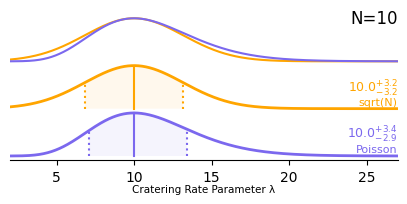

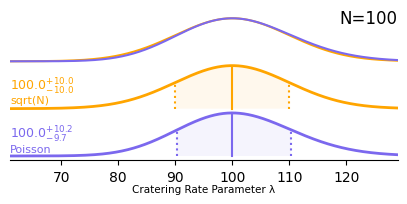

In [3]:
Ns = [0, 1, 2, 5, 10, 100]
xlims = [xlim, xlim, xlim, [-1, 15], [2, 27], [61, 129]]
dns = 5 * [None] + [0]
for i in range(6):
    N = Ns[i]
    fig = plt.figure(figsize=(5, 1.9))
    ax = fig.add_subplot(111)
    customized_PDF_comparison_plot(
        N, '', xlim=xlims[i], dn=dns[i]
    )
    plt.subplots_adjust(wspace=0.1, hspace=0.28)
    pfig = plt.gcf()
    pfig.savefig(
        'figs/sqrtN_comparison_plot_N' + str(N) + '.pdf', 
        bbox_inches='tight'
    )

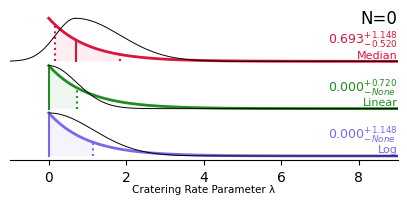

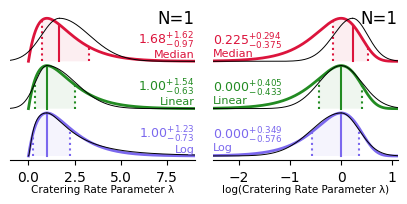

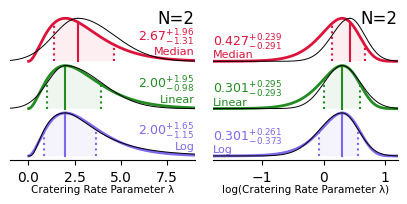

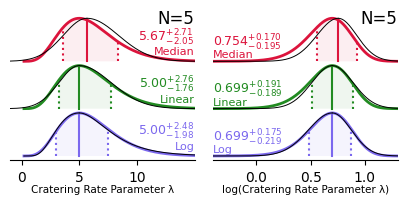

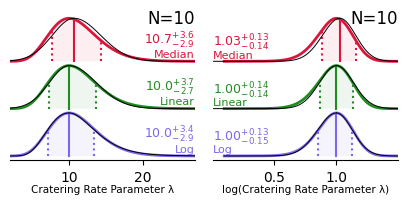

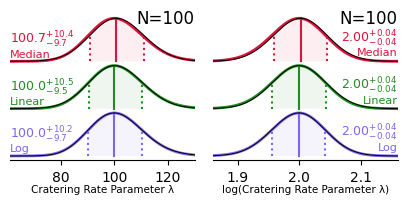

In [17]:
Ns = [0, 1, 2, 5, 10, 100]
xlims = [xlim, xlim, xlim, [-1, 14.99], [2, 27], [61, 130]]
log_xlims = [
    None, [-2.5, 1.1], [-1.8, 1.2], 
    [-0.4, 1.3], [0.01, 1.49], [1.86, 2.16]
]
dns = 5 * [None] + [0]
for i in range(6):
    N = Ns[i]
    letter = letters[i]
    fig = plt.figure(figsize=(5, 1.9))
    if N == 0:
        ax = fig.add_subplot(111)
        customized_error_bar_comparison_plot(
            N, '', xlim=xlims[i], dn=dns[i]
        )
    else:
        ax = fig.add_subplot(121)
        customized_error_bar_comparison_plot(
            N, '', xlim=xlims[i], dn=dns[i]
        )
        ax = fig.add_subplot(122)
        pgs = -0.05
        if N == 100:
            pgs = 0
        customized_error_bar_comparison_log_plot(
            N, '', xlim=log_xlims[i], dn=dns[i], pdf_gap_shift=pgs
        )
    plt.subplots_adjust(wspace=0.1, hspace=0.28)
    pfig = plt.gcf()
    pfig.savefig(
        'figs/error_bar_comparison_plot_N' + str(N) + '.pdf', 
        bbox_inches='tight'
    )

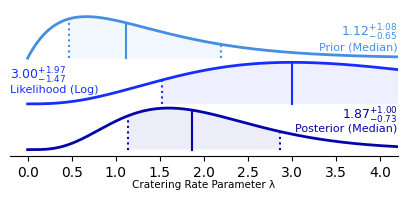

In [40]:
fig = plt.figure(figsize=(5, 1.9))
ax = fig.add_subplot(111)
N = 3
customized_prior_PDF_plot(
    N, '', division_factor=1, xlim=[-0.2, 4.2], ppgs=-0.02,
    m_prior=0.0005, m_likelihood=0.5, m_posterior=0.4, llsy=llsy
)
pfig = plt.gcf()
pfig.savefig(
    'figs/PDF_comparison_plot_N' + str(N) + '.pdf', 
    bbox_inches='tight'
)

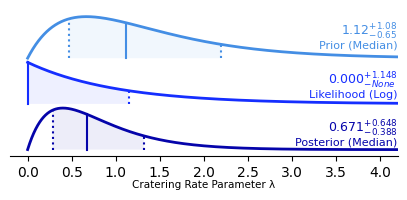

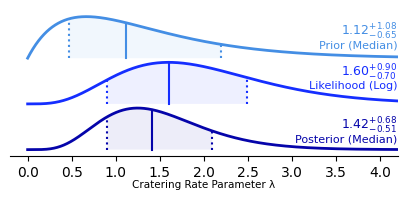

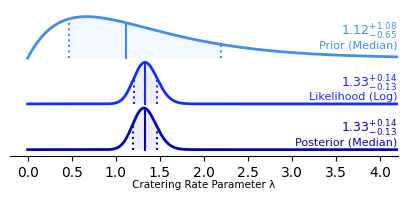

In [41]:
for N, i, df in zip([0, 4, 100], range(14, 17), [1, 2.5, 75]):
    fig = plt.figure(figsize=(5, 1.9))
    ax = fig.add_subplot(111)
    if i == 15:
        llsy = -0.07
    else:
        llsy = 0
    customized_prior_PDF_plot(
        N, '', division_factor=df, xlim=[-0.2, 4.2], ppgs=-0.02,
        m_prior=4.1, m_likelihood=4.2, m_posterior=3.2, llsy=llsy
    )
    pfig = plt.gcf()
    pfig.savefig(
        'figs/PDF_comparison_plot_N' + str(N) + '.pdf', 
        bbox_inches='tight'
    )